# Drop Test, Shapley Value

No feature less than n, n=3

In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as sp_stats
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import LZH_Utilities as utl
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm

In [3]:
mpl.rcParams['figure.dpi'] = 300
torch.set_num_threads(16)

## Function Definitions

In [4]:
def mean_bias_error(y_true, y_pred):
    return np.mean(y_true - y_pred)

In [5]:
def transpose_stack(arr):
    return np.array([arr]).T

def tsr(arr):
    return torch.tensor(arr)

def plot(x, y, x_label="", y_label="", legend="", title=""):
    # plt.figure(figsize=[8, 6], dpi=300)
    plt.figure(figsize=[8, 6])
    
    if (type(legend) is list):
        for yy in y:
            plt.plot(x, yy)
        plt.legend(legend)
    else: 
        plt.plot(x, y)
        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [6]:
def plot_diff_percentage(x, y, x_label="", y_label="", title=""):
    # plt.figure(figsize=[8, 6], dpi=300)
    plt.figure(figsize=[8, 6])
    
    x_fit = np.linspace(0, 100, 1000)
    y_fit1 = np.polyval(np.polyfit(x, y, 1), x_fit)
    
    plt.scatter(x, y, s=0.5, c='k')
    plt.plot(x_fit, y_fit1, "r")
        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(["linear regression", "data"])
    plt.ylim([0, 100])
    plt.xlim([0, 100])
    plt.title(title)
    plt.show()
    
    result = sp_stats.linregress(x, y)
    print("     slope: {0}".format(result.slope))
    print(" intercept: {0}".format(result.intercept))
    print("corr coeff: {0}".format(result.rvalue))
    print("  variance: {0}".format(result.rvalue ** 2))

In [7]:
class ResultIndexer:
    def __init__(self, df, restriction=None):
        self.df = df
        
        if (restriction is None):
            self.restriction = []
        else:
            self.restriction = restriction
    
    def __call__(self, metric=None):
        """
        get the value in the current class where all label is not dropped
        
        metric: 1) None, then return all metrics
                2) string, one of the "MAE", "MBE", "RMSE", or "RVALUE", 
                   then, return one of the metrics. 
        """
        df = self.df.copy()
        
        for key in utl.set_difference(X_label, self.restriction):
            df = df[df[key]]
        
        ret_dict = {
            "MAE": {"GRU": df["mae_GRU"].values[0], "LINEAR": df["mae_LINEAR"].values[0]},
            "MBE": {"GRU": df["mbe_GRU"].values[0], "LINEAR": df["mbe_LINEAR"].values[0]},
            "RMSE": {"GRU": df["rmse_GRU"].values[0], "LINEAR": df["rmse_LINEAR"].values[0]},
            "RVALUE": {"GRU": df["r_value_GRU"].values[0], "LINEAR": df["r_value_LINEAR"].values[0]}
        }
        
        if (metric is None): 
            return ret_dict
        else:
            return ret_dict[metric.upper()]
    
    def __getitem__(self, key):
        """
        get a ResultIndexer where given key is dropped
        
        key: string or list of string
        """
        
        if (isinstance(key, str)):
            return ResultIndexer(self.df[self.df[key] == False].copy(), self.restriction + [key])
        else:
            ret_val = self.df.copy()
            for key_item in key:
                ret_val = ret_val[ret_val[key_item] == False]
            return ResultIndexer(ret_val, self.restriction + key)
    
    def get_dataframe(self):
        """
        get the dataframe in the current class
        """
        return self.df.copy()
    
    def get_value(self, r_value_type=None):
        """
        get the value in the current class, where the restriction is the weakest
        
        r_value_type, string-like, "GRU" or "LINEAR". 
            if it is specified then return a float of r_value, 
            otherwise return a dictionary of both value. 
        """
        return self(r_value_type)
    
    def drop(self, key):
        return self[key]

## Data

In [8]:
df = utl.read_time_series_data("full_rank_dataset")

In [9]:
df[0]["TCC_FB"] = 0
for idx in np.arange(8):
    df[idx+1]["TCC_FB"] = df[idx]["TCC"]

In [10]:
df[0]["Delta_Subsidence"] = 0
for idx in np.arange(len(df) - 1):
    df[idx + 1]["Delta_Subsidence"] = df[idx + 1]["Subsidence"] - df[idx]["Subsidence"]

In [11]:
column_labels = ['LTS', 'SST', 'Subsidence', 'Night_Day', 'RH', 'q', 'wsp', "TCC_FB", 'TCC']
X_label = ['LTS', 'SST', 'Subsidence', 'Night_Day', 'RH', 'q', 'wsp', "TCC_FB"]
y_label = ['TCC']

for idx in np.arange(len(df)):
    df[idx] = df[idx][column_labels]

In [12]:
idx_test_set = np.random.choice(np.arange(df[0].shape[0]), [int(0.1 * df[0].shape[0])], False)
idx_training_set = np.delete(np.arange(df[0].shape[0]), idx_test_set)

In [13]:
def slicing_sample(df, label_list, set1, set2):
    """
    return (list1, list2)
    """
    df_full = np.array([df[time][label_list].to_numpy() for time in np.arange(len(df))])
    return (df_full[:, set1], df_full[:, set2])

## Model

### GRU

#### Definition

In [14]:
class MLTCC_Model_GRU_Normalized:
    def __init__(self):
        self.batch_size = 10000
        self.step_size = 1e-3
        
    def forward(self, X):
        """
        X := [LTS, SST, Subsidence], (sample_size, 4) like tensor
        y := [TCC],                  (sample_size, 1) like tensor
        """
#         seq_X_result = []
#         for seq_X in X:
#             seq_X_result.append(torch.relu(self.fc1(seq_X.float())))
#         seq_X_result = tsr(seq_X_result)
        # normalize
        newX = []
        for idx in np.arange(X.shape[0]):
            newX.append(self.NMR.normalize_input(X[idx]).detach().numpy())
        X = torch.tensor(np.array(newX))

        X = X.float()
    
        X_gru_outputs, hn = self.gru(X)
        X = torch.relu(X_gru_outputs[-1]) # use last output
        
        X = torch.relu(self.fc1(X))
        X = torch.relu(self.fc2(X))
        X = torch.relu(self.fc3(X))
        X = self.fc4(X)
        
        return self.NMR.denormalize_output(X)
    
    def forward_numpy(self, X):
         return self.forward(torch.tensor(X)).detach().numpy()
    
    def loss(self, y, y_hat):
        """
        y := [TCC],                  (sample_size, 1) like tensor
        y_hat := [TCC],              (sample_size, 1) like tensor
        """
        return F.mse_loss(y.float(), y_hat.float())
    
    def train(self, X, y_hat, max_epoch):
        """
        X := [LTS, SST, Subsidence], (sample_size, 4) like matrix
        y_hat := [TCC],              (sample_size, 1) like matrix
        """
        sample_count = X.shape[1]
        
        epoch_num = []
        losses = []
        
        for i in np.arange(max_epoch):
            for idx_batch in np.arange(int(sample_count / self.batch_size)) * self.batch_size:
                X_batch = torch.tensor(X[:, idx_batch:idx_batch + self.batch_size, :])
                y_hat_batch = torch.tensor(y_hat[idx_batch:idx_batch + self.batch_size, :])
                y_batch = self.forward(X_batch)
                loss = self.loss(y_batch.t(), y_hat_batch.t())
                
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()
                
            idx_rand = np.random.randint(0, sample_count, [self.batch_size])
            X_batch = torch.tensor(X[:, idx_rand, :]).float()
            y_hat_batch = torch.tensor(y_hat[idx_rand, :]).float()
            y_batch = self.forward(X_batch)
            loss = self.loss(y_batch, y_hat_batch)
            
            epoch_num.append(i)
            losses.append(loss.item())
        
        return (epoch_num, losses)
    
    
    def train_time_series(self, X, y_hat, max_epoch, max_epoch_per_time):
        """
        X := [LTS, SST, Subsidence], (sample_size, 4) like matrix
        y_hat := [TCC],              (sample_size, 1) like matrix
        """
        
        # begin initialization
        self.NMR = utl.Normalizer()
        
        self.input_size = X.shape[2]
        self.output_size = y_hat.shape[2]
        
        h_gru = 50
        h1 = 20
        h2 = 40
        h3 = 20
        
        self.gru = nn.GRU(self.input_size, h_gru, 2, batch_first=False)   # (seq, batch, feature)
        self.fc1 = nn.Linear(h_gru, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, self.output_size)
        
        variable_list = [
                self.fc1.weight, self.fc1.bias,
                self.fc2.weight, self.fc2.bias,
                self.fc3.weight, self.fc3.bias,
                self.fc4.weight, self.fc4.bias
            ]
        for all_weights in self.gru.all_weights:
            for weights in all_weights:
                variable_list.append(weights)
        
        
        self.optim = torch.optim.Adam(
            variable_list,
            lr=self.step_size
        )
        
        # end initialization
        
        progress_bar = utl.TimedProgressBar(max_epoch).update(msg="Initialization")
        
        # setting normalizer
        # flatten X and y_hat
        X_flat = np.concatenate(X, axis=0)
        y_hat_flat = np.concatenate(y_hat, axis=0)
        
        self.NMR.set_mean_and_sd(torch.tensor(X_flat), torch.tensor(y_hat_flat))
        
        
        full_losses = np.array([])

        T_running = utl.get_runtime_marker()
        for i in np.arange(max_epoch):
            for time in np.arange(9):
                (x_axis, losses) = self.train(X[:time+1, :, :], y_hat[time, :, :], max_epoch_per_time)
                full_losses = np.concatenate((full_losses, losses))
            progress_bar.update(i + 1, "epoch {0}".format(i))
            
        print()
            
            
        return (np.arange(len(full_losses)) + 1, full_losses)

#### Training

In [15]:
# y_hat_train, y_hat_test = slicing_sample(df, y_label, idx_training_set, idx_test_set)

# result = {}

# for X_partial_label in utl.powerset(X_label, keep_longer_than=0):
#     print("Drop {0}, ".format("{0}".format(utl.set_difference(X_label, X_partial_label))))
    
#     X_train, X_test = slicing_sample(df, X_partial_label, idx_training_set, idx_test_set)
    
#     tcc_model_gru = MLTCC_Model_GRU_Normalized()
#     tcc_model_gru.train_time_series(X_train, y_hat_train, 50, 4)
    
#     poly_y_test = y_hat_test[-1, :, -1]
#     poly_y_test_fit = tcc_model_gru.forward_numpy(X_test)[:, -1]
    
#     result["Drop {0}".format(utl.set_difference(X_label, X_partial_label))] = {
#         "r_value": sp_stats.linregress(poly_y_test, poly_y_test_fit).rvalue,
#         "rmse": mean_squared_error(poly_y_test, poly_y_test_fit, squared=False),
#         "mae": mean_absolute_error(poly_y_test, poly_y_test_fit),
#         "mbe": mean_bias_error(poly_y_test, poly_y_test_fit),
#     }
#     for label in X_label:
#         result["Drop {0}".format(utl.set_difference(X_label, X_partial_label))][label] = label in X_partial_label

# pd.DataFrame(
#     [
#         {label: result[label]["r_value"] for label in result},
#         {label: result[label]["r_value"] - result["Drop []"]["r_value"]  for label in result}
#     ],
#     index=["Value", "Relative"]
# )

# df_res = pd.DataFrame(
#     [result[label] for label in result]
# )
# df_res.to_csv("Output/drop_test/GRU_drop_test_result_ALL.csv", index=False)

### Linear

In [16]:
y_hat_train, y_hat_test = slicing_sample(df, y_label, idx_training_set, idx_test_set)

y_hat_train, y_hat_test = np.concatenate(y_hat_train, axis=0)[:, -1], np.concatenate(y_hat_test, axis=0)[:, -1]

result = {}

for X_partial_label in tqdm(utl.powerset(X_label)):
    
    if (len(X_partial_label) < 1):
        continue
    
    X_train, X_test = slicing_sample(df, X_partial_label, idx_training_set, idx_test_set)

    X_train, X_test = np.concatenate(X_train, axis=0), np.concatenate(X_test, axis=0)

    linear_model = LinearRegression().fit(X_train, y_hat_train)

    poly_y_test = y_hat_test
    poly_y_test_fit = linear_model.predict(X_test)

    result["Drop {0}".format(utl.set_difference(X_label, X_partial_label))] = {
        "r_value": sp_stats.linregress(poly_y_test, poly_y_test_fit).rvalue,
        "rmse": mean_squared_error(poly_y_test, poly_y_test_fit, squared=False),
        "mae": mean_absolute_error(poly_y_test, poly_y_test_fit),
        "mbe": mean_bias_error(poly_y_test, poly_y_test_fit),
    }
    for label in X_label:
        result["Drop {0}".format(utl.set_difference(X_label, X_partial_label))][label] = label in X_partial_label

100%|██████████| 256/256 [00:26<00:00,  9.84it/s]


### Merge Result

In [17]:
# load checkpoint and combine LINEAR result
df_res = pd.read_csv(
    "Output/drop_test/GRU_drop_test_result_ALL.csv"
).merge(
    right=pd.DataFrame(
        [result[label] for label in result]
    ), 
    how="inner",
    on=X_label,
    suffixes=["_GRU", "_LINEAR"]
)



In [18]:
df_res = pd.concat(
    [
        df_res, 
        pd.DataFrame([{
            'r_value_GRU': 0, 
            'rmse_GRU': np.nan, 
            'mae_GRU': np.nan, 
            'mbe_GRU': np.nan, 

            'LTS': False, 
            'SST': False,
            'Subsidence': False, 
            'Night_Day': False, 
            'RH': False, 
            'q': False, 
            'wsp': False, 
            'TCC_FB': False,

            'r_value_LINEAR': 0,
            'rmse_LINEAR': np.nan, 
            'mae_LINEAR': np.nan,
            'mbe_LINEAR': np.nan,
        }])
    ],
    ignore_index=True
)

## Visualization

In [38]:
contribution = {}

In [39]:
labels = X_label[:]
metrics = ["MAE", "MBE", "RMSE", "RVALUE"]
models = ["GRU", "LINEAR"]

In [40]:
for shap_label in X_label:
    
    working_columns = labels[:]
    working_columns.remove(shap_label)

    contribution_on_label = {
        "MAE":{"GRU": [], "LINEAR": []},
        "MBE":{"GRU": [], "LINEAR": []},
        "RMSE":{"GRU": [], "LINEAR": []},
        "RVALUE": {"GRU": [], "LINEAR": []}
    }

    # do not keep the one with all element
    for drop_labels in utl.powerset(working_columns, keep_shorter_than=len(working_columns)-3):
    # for drop_labels in utl.powerset(working_columns):
        res_with = ResultIndexer(df_res)[drop_labels]()
        res_without = ResultIndexer(df_res)[drop_labels].drop(shap_label)()

        for metric in metrics:

            res_with[metric]
            res_without[metric]

            contribution_on_label[metric]["GRU"].append(res_with[metric]["GRU"] - res_without[metric]["GRU"])
            contribution_on_label[metric]["LINEAR"].append(res_with[metric]["LINEAR"] - res_without[metric]["LINEAR"])

    contribution[shap_label] = contribution_on_label

In [41]:
labels = X_label[:]
metrics = ["MAE", "MBE", "RMSE", "RVALUE"]
models = ["GRU", "LINEAR"]

shapley_values = []

keys_flat = [(label, metric, model) for label in labels for metric in metrics for model in models]

for label, metric, model in keys_flat:
    shapley_values.append({
        "label": label,
        "metric": metric, 
        "model": model, 
        "shapley_value": np.nanmean(contribution[label][metric][model]),
        "shapley_value_std": np.nanstd(contribution[label][metric][model])
    })

shapley_df = pd.DataFrame(shapley_values)

In [42]:
contribution_NO_TCC = {}
for shap_label in X_label[:-1]:
    
    working_columns = labels[:-1]
    working_columns.remove(shap_label)
    

    contribution_on_label = {
        "MAE":{"GRU": [], "LINEAR": []},
        "MBE":{"GRU": [], "LINEAR": []},
        "RMSE":{"GRU": [], "LINEAR": []},
        "RVALUE": {"GRU": [], "LINEAR": []}
    }

    # do not keep the one with all element
    # for drop_labels in utl.powerset(working_columns, keep_shorter_than=len(working_columns)):
    for drop_labels in utl.powerset(working_columns):
        res_with = ResultIndexer(df_res)[drop_labels]()
        res_without = ResultIndexer(df_res)[drop_labels].drop(shap_label)()

        for metric in metrics:

            res_with[metric]
            res_without[metric]

            contribution_on_label[metric]["GRU"].append(res_with[metric]["GRU"] - res_without[metric]["GRU"])
            contribution_on_label[metric]["LINEAR"].append(res_with[metric]["LINEAR"] - res_without[metric]["LINEAR"])

    contribution_NO_TCC[shap_label] = contribution_on_label

In [43]:
labels = X_label[:-1]
metrics = ["MAE", "MBE", "RMSE", "RVALUE"]
models = ["GRU", "LINEAR"]

shapley_values_no_TCC_FB = []

keys_flat = [(label, metric, model) for label in labels for metric in metrics for model in models]

for label, metric, model in keys_flat:
    # print(label, metric, model)
    shapley_values_no_TCC_FB.append({
        "label": label,
        "metric": metric, 
        "model": model, 
        "shapley_value": np.nanmean(contribution_NO_TCC[label][metric][model])
    })

shapley_df_no_TCC_FB = pd.DataFrame(shapley_values_no_TCC_FB)

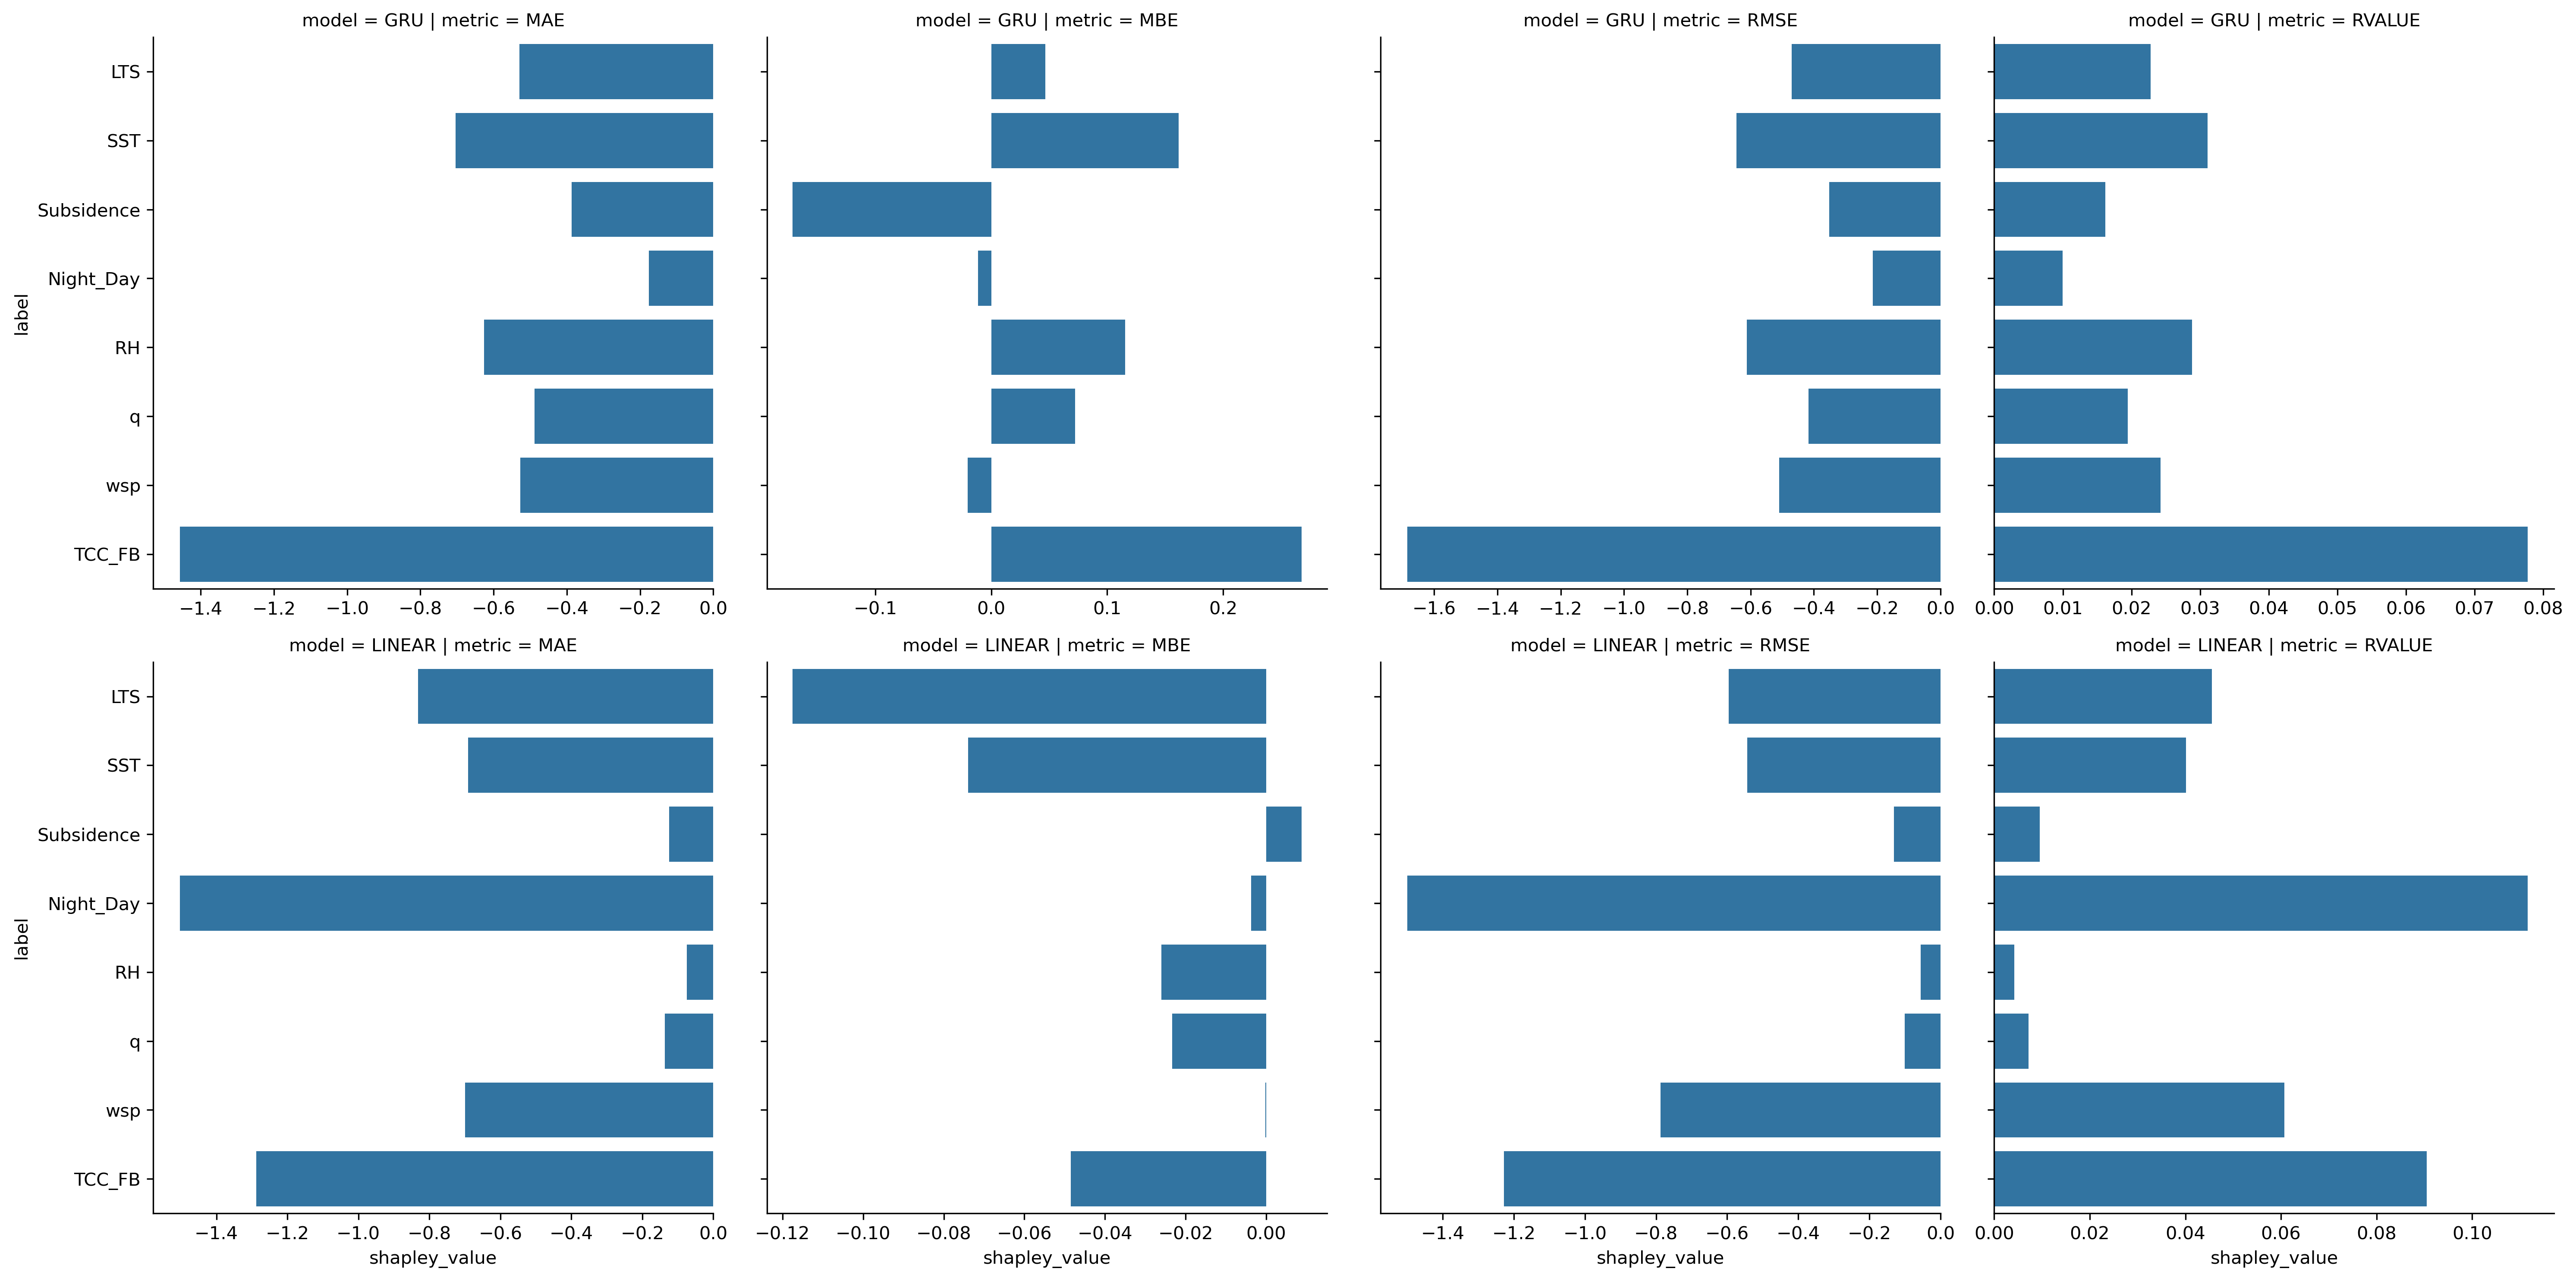

In [44]:
sns.catplot(
    data=shapley_df,
    x="shapley_value",
    y="label",
    col="metric",
    row="model",
    kind="bar",
    sharex=False
)
plt.show()

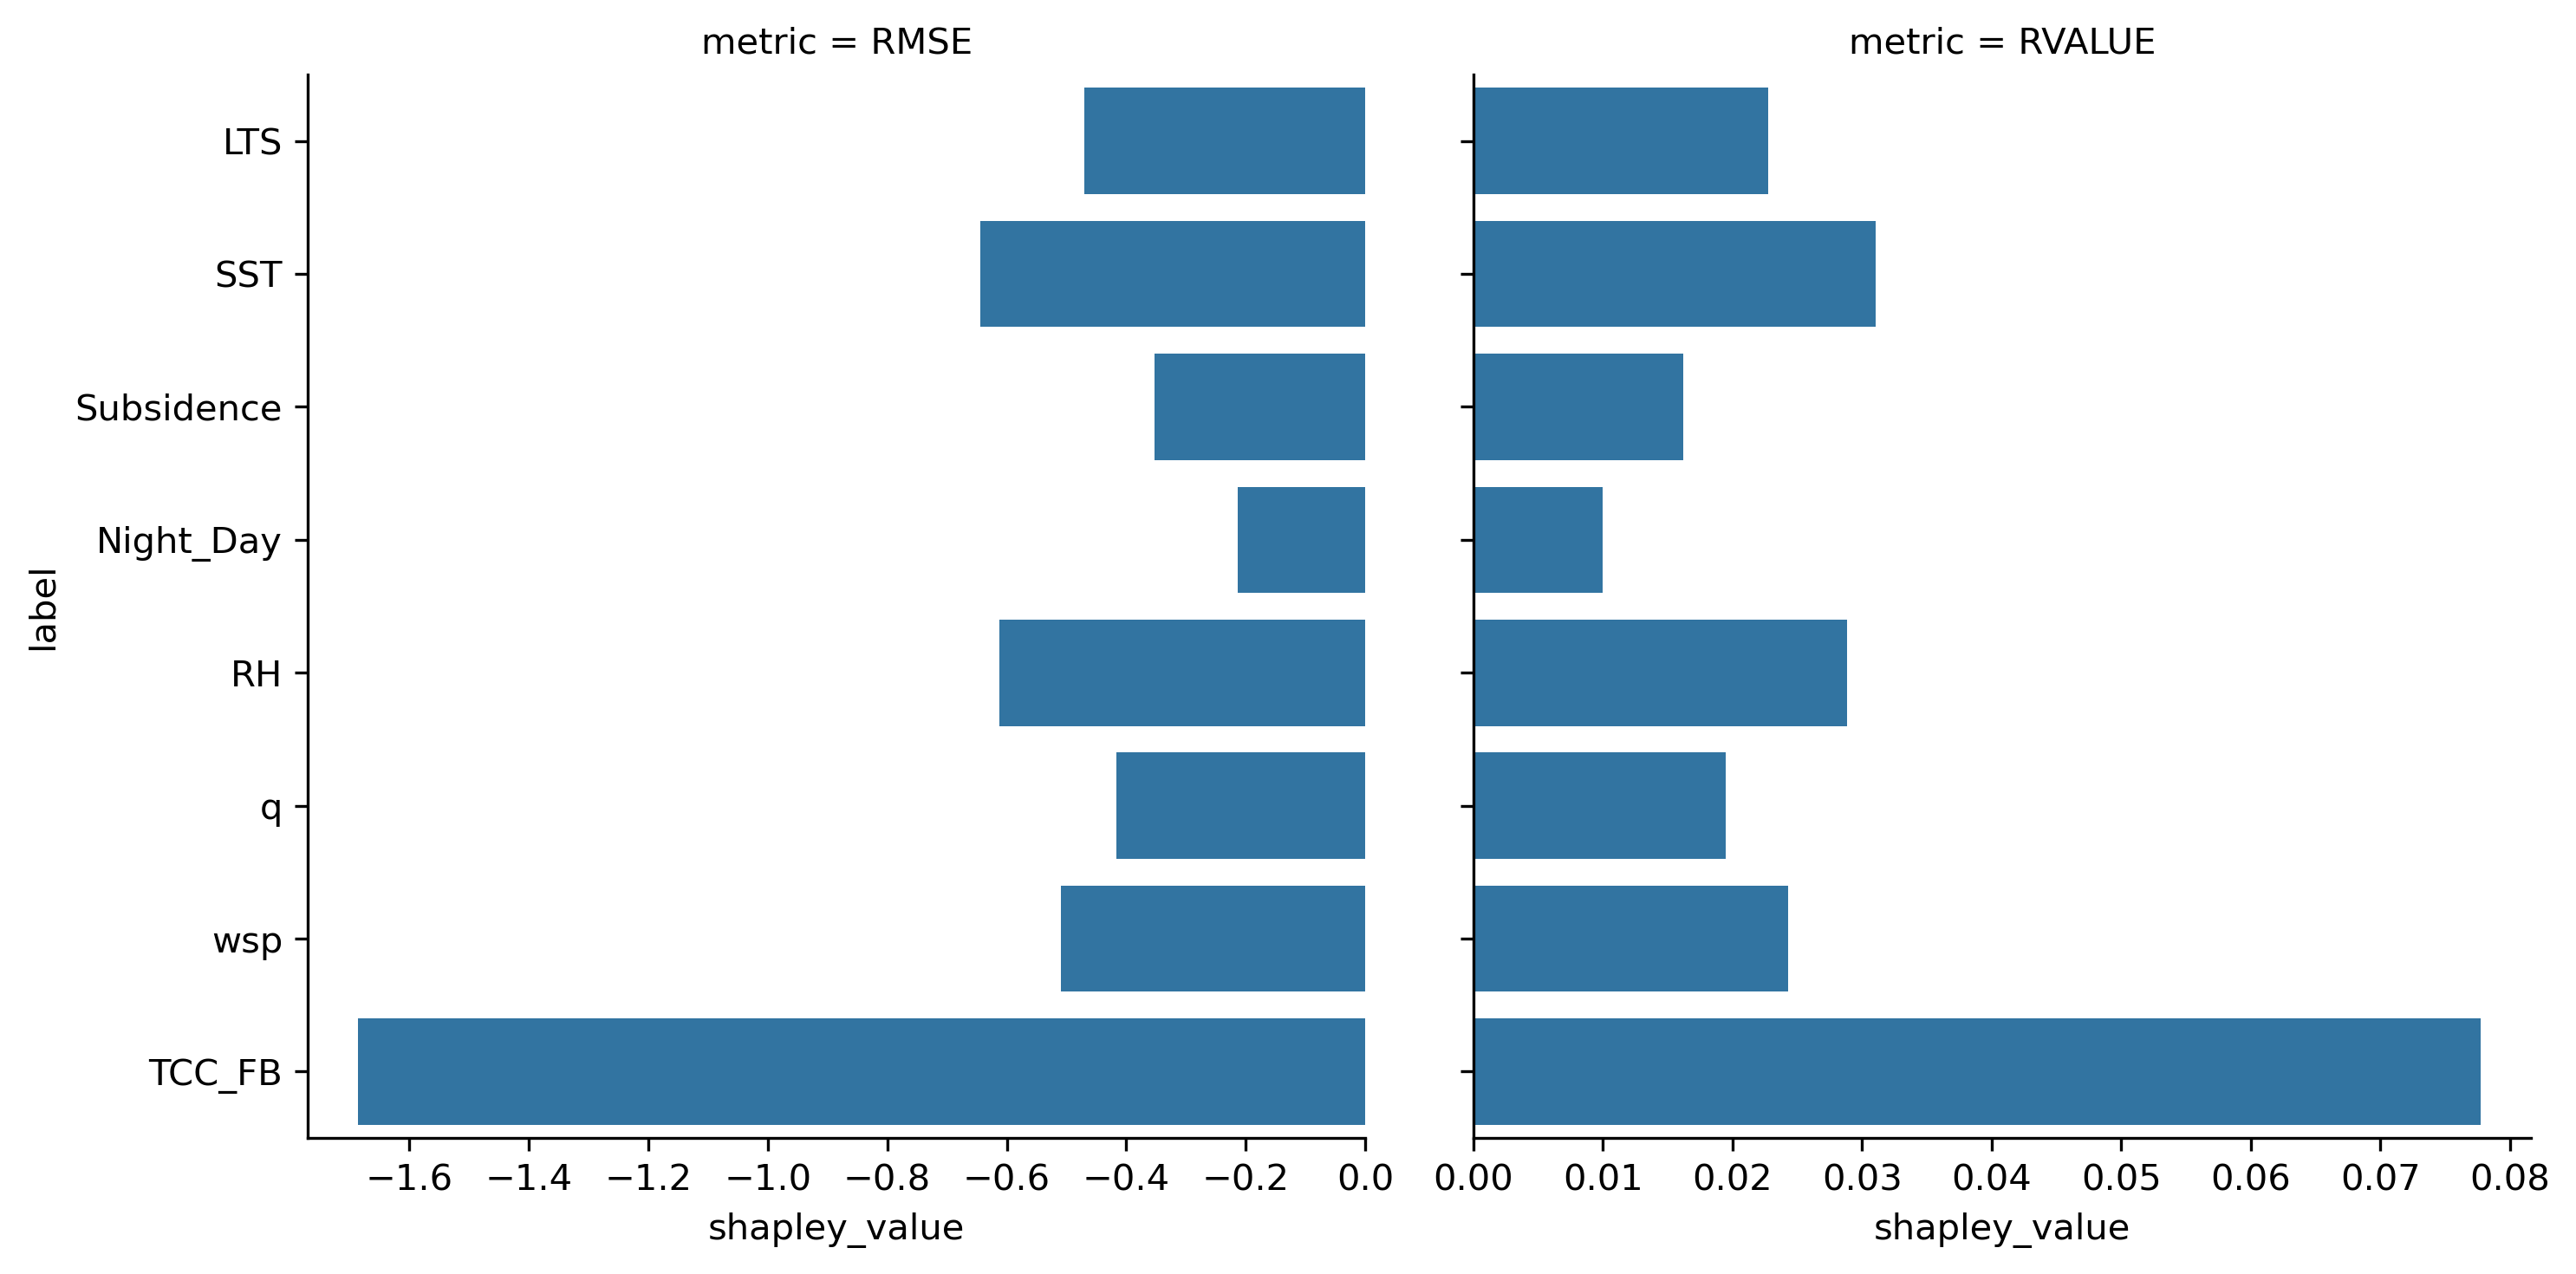

In [45]:
sns.catplot(
    data=shapley_df[
        (shapley_df["model"] == "GRU")
        & ((shapley_df["metric"] == "RMSE") | (shapley_df["metric"] == "RVALUE"))
    ],
    x="shapley_value",
    y="label",
    col="metric",
    kind="bar",
    sharex=False
)
plt.show()

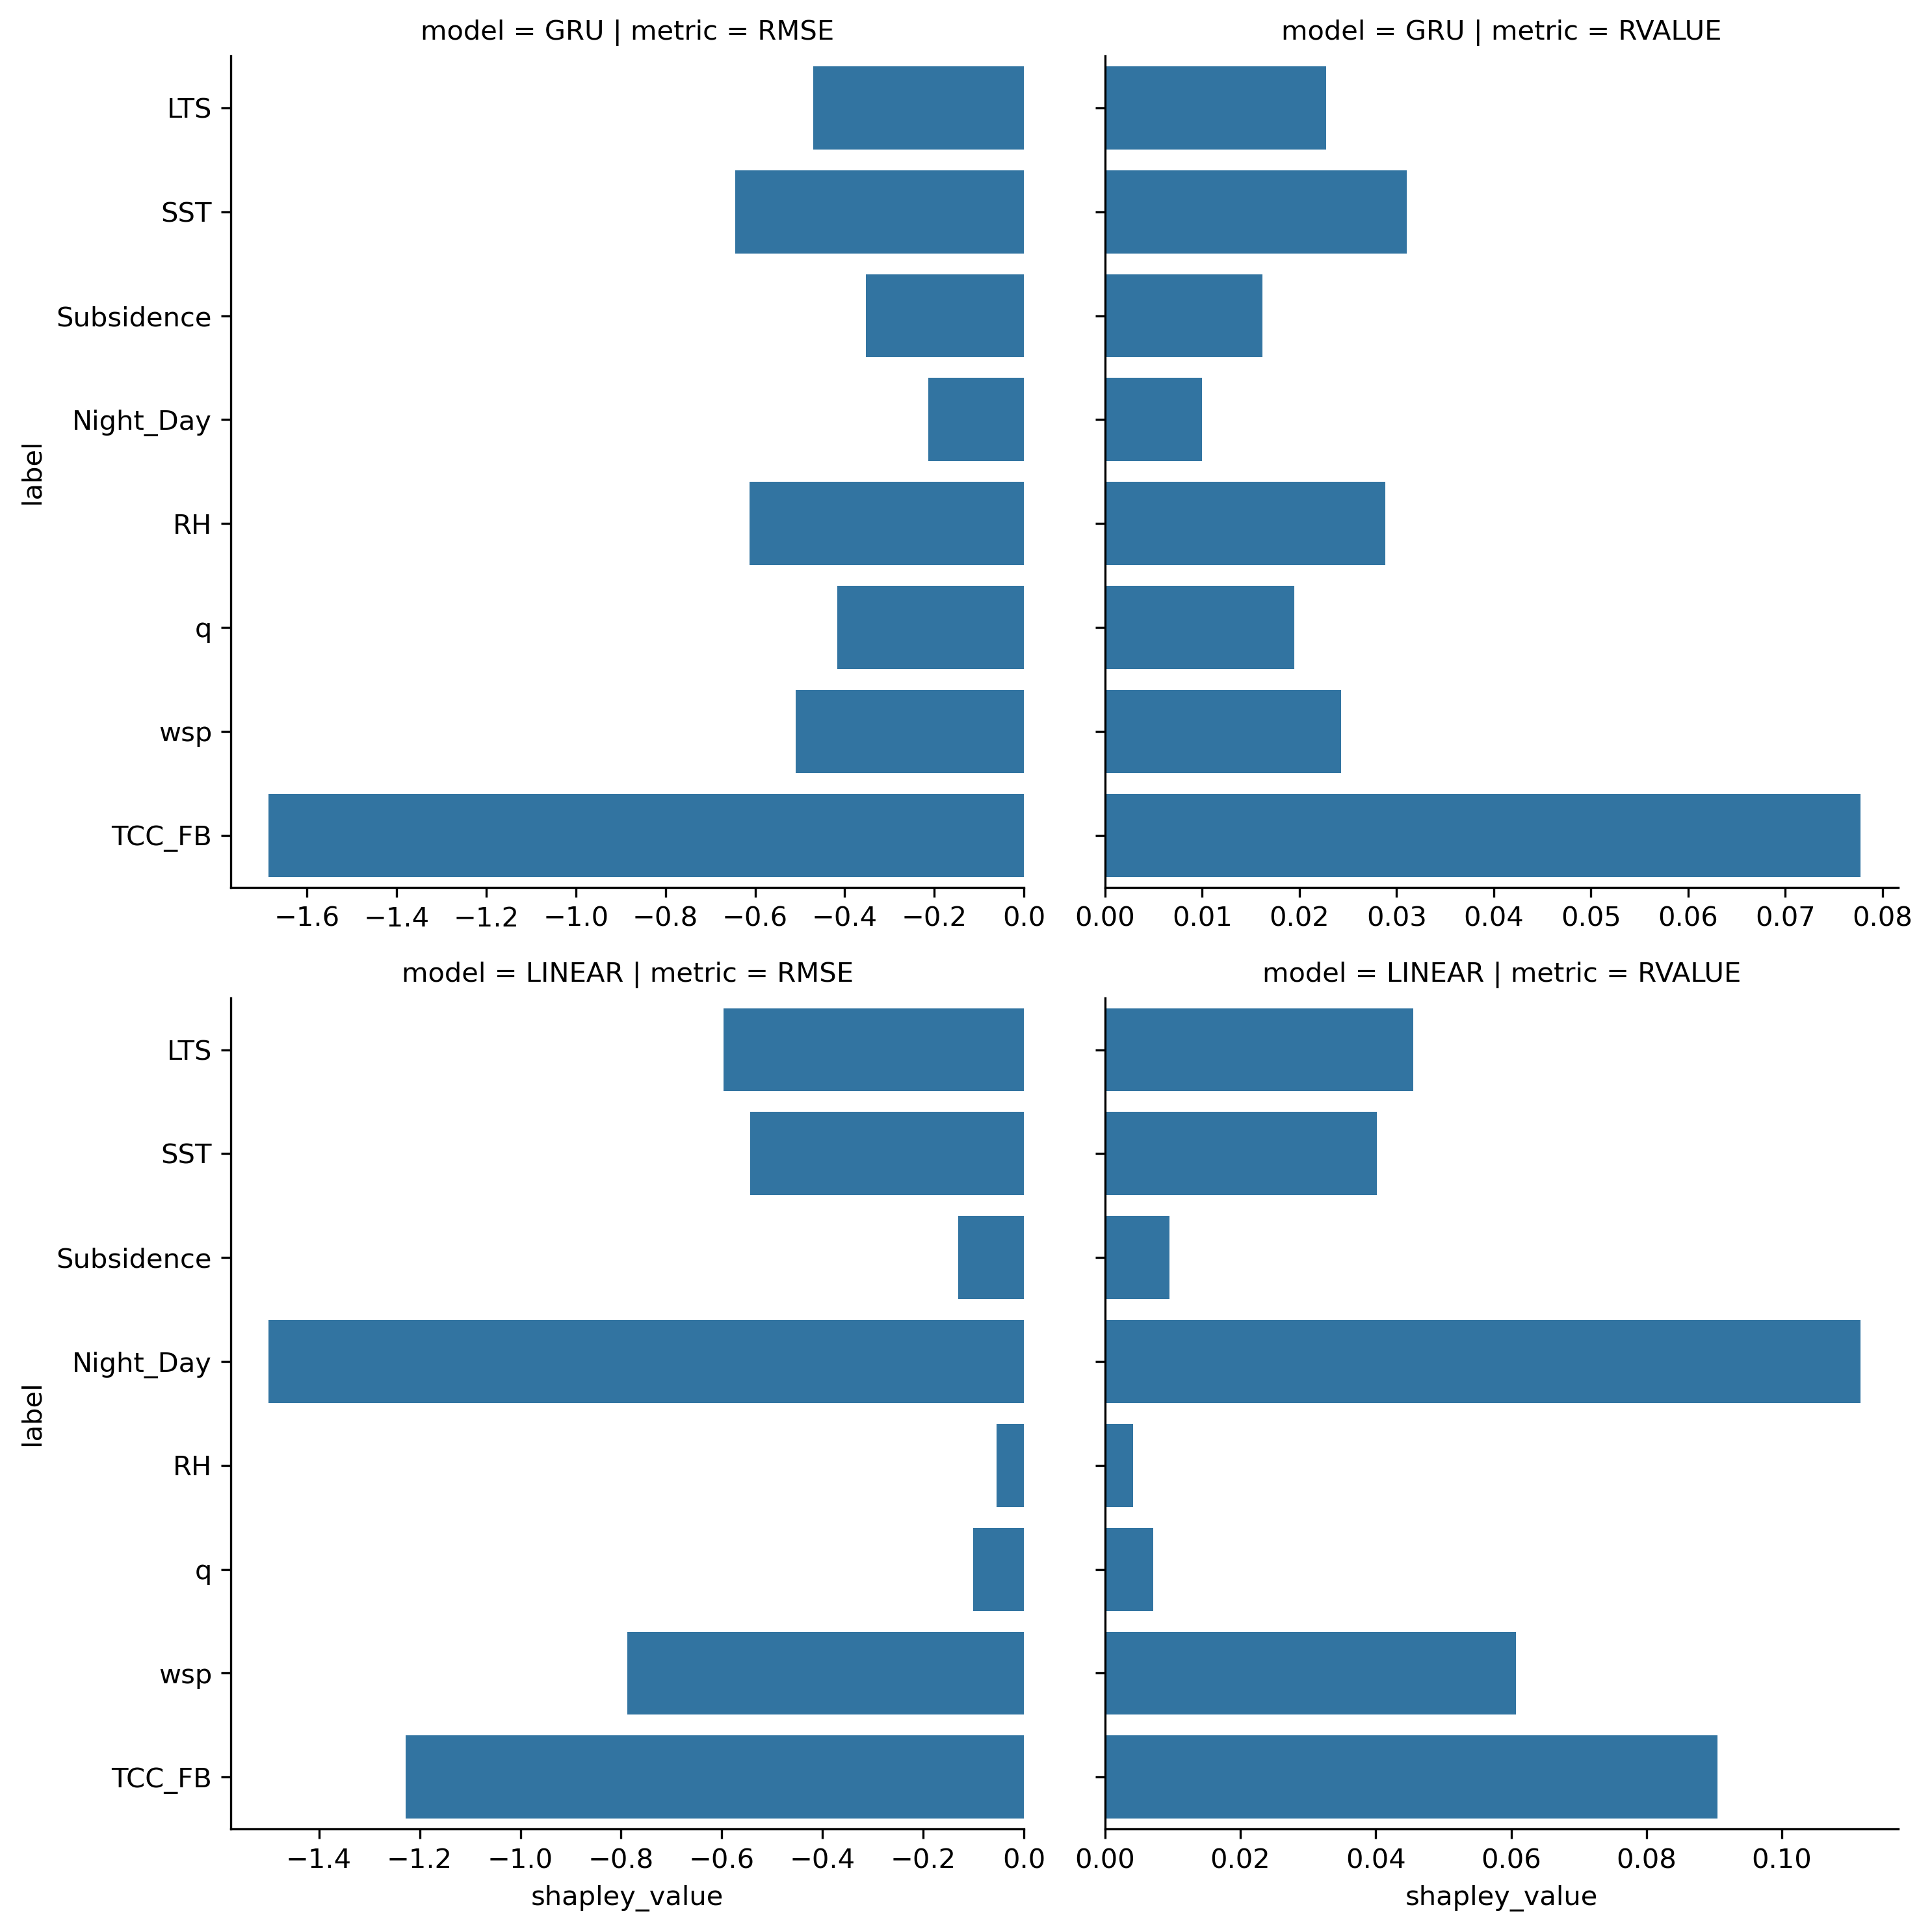

In [46]:
sns.catplot(
    data=shapley_df[
        (shapley_df["metric"] == "RMSE") | (shapley_df["metric"] == "RVALUE")
    ],
    x="shapley_value",
    y="label",
    col="metric",
    row="model",
    kind="bar",
    sharex=False
)
plt.show()

In [47]:
len(contribution["LTS"]["RVALUE"]["GRU"])

64

In [48]:
# Shapley Value with Error Bar

parameter_names = list(contribution.keys())
metric_types = ["RVALUE"]
model_types = list(contribution["LTS"]["RVALUE"])

shapley_values_no_average = []

for parameter_name in parameter_names:
    for metric_type in metric_types:
        for model_type in model_types:
            for sv in contribution[parameter_name][metric_type][model_type]:
                shapley_values_no_average.append({
                    "label": parameter_name,
                    "metric_type": metric_type,
                    "model": model_type,
                    "shapley_value": sv,
                })

shapley_values_no_average_df = pd.DataFrame(shapley_values_no_average)

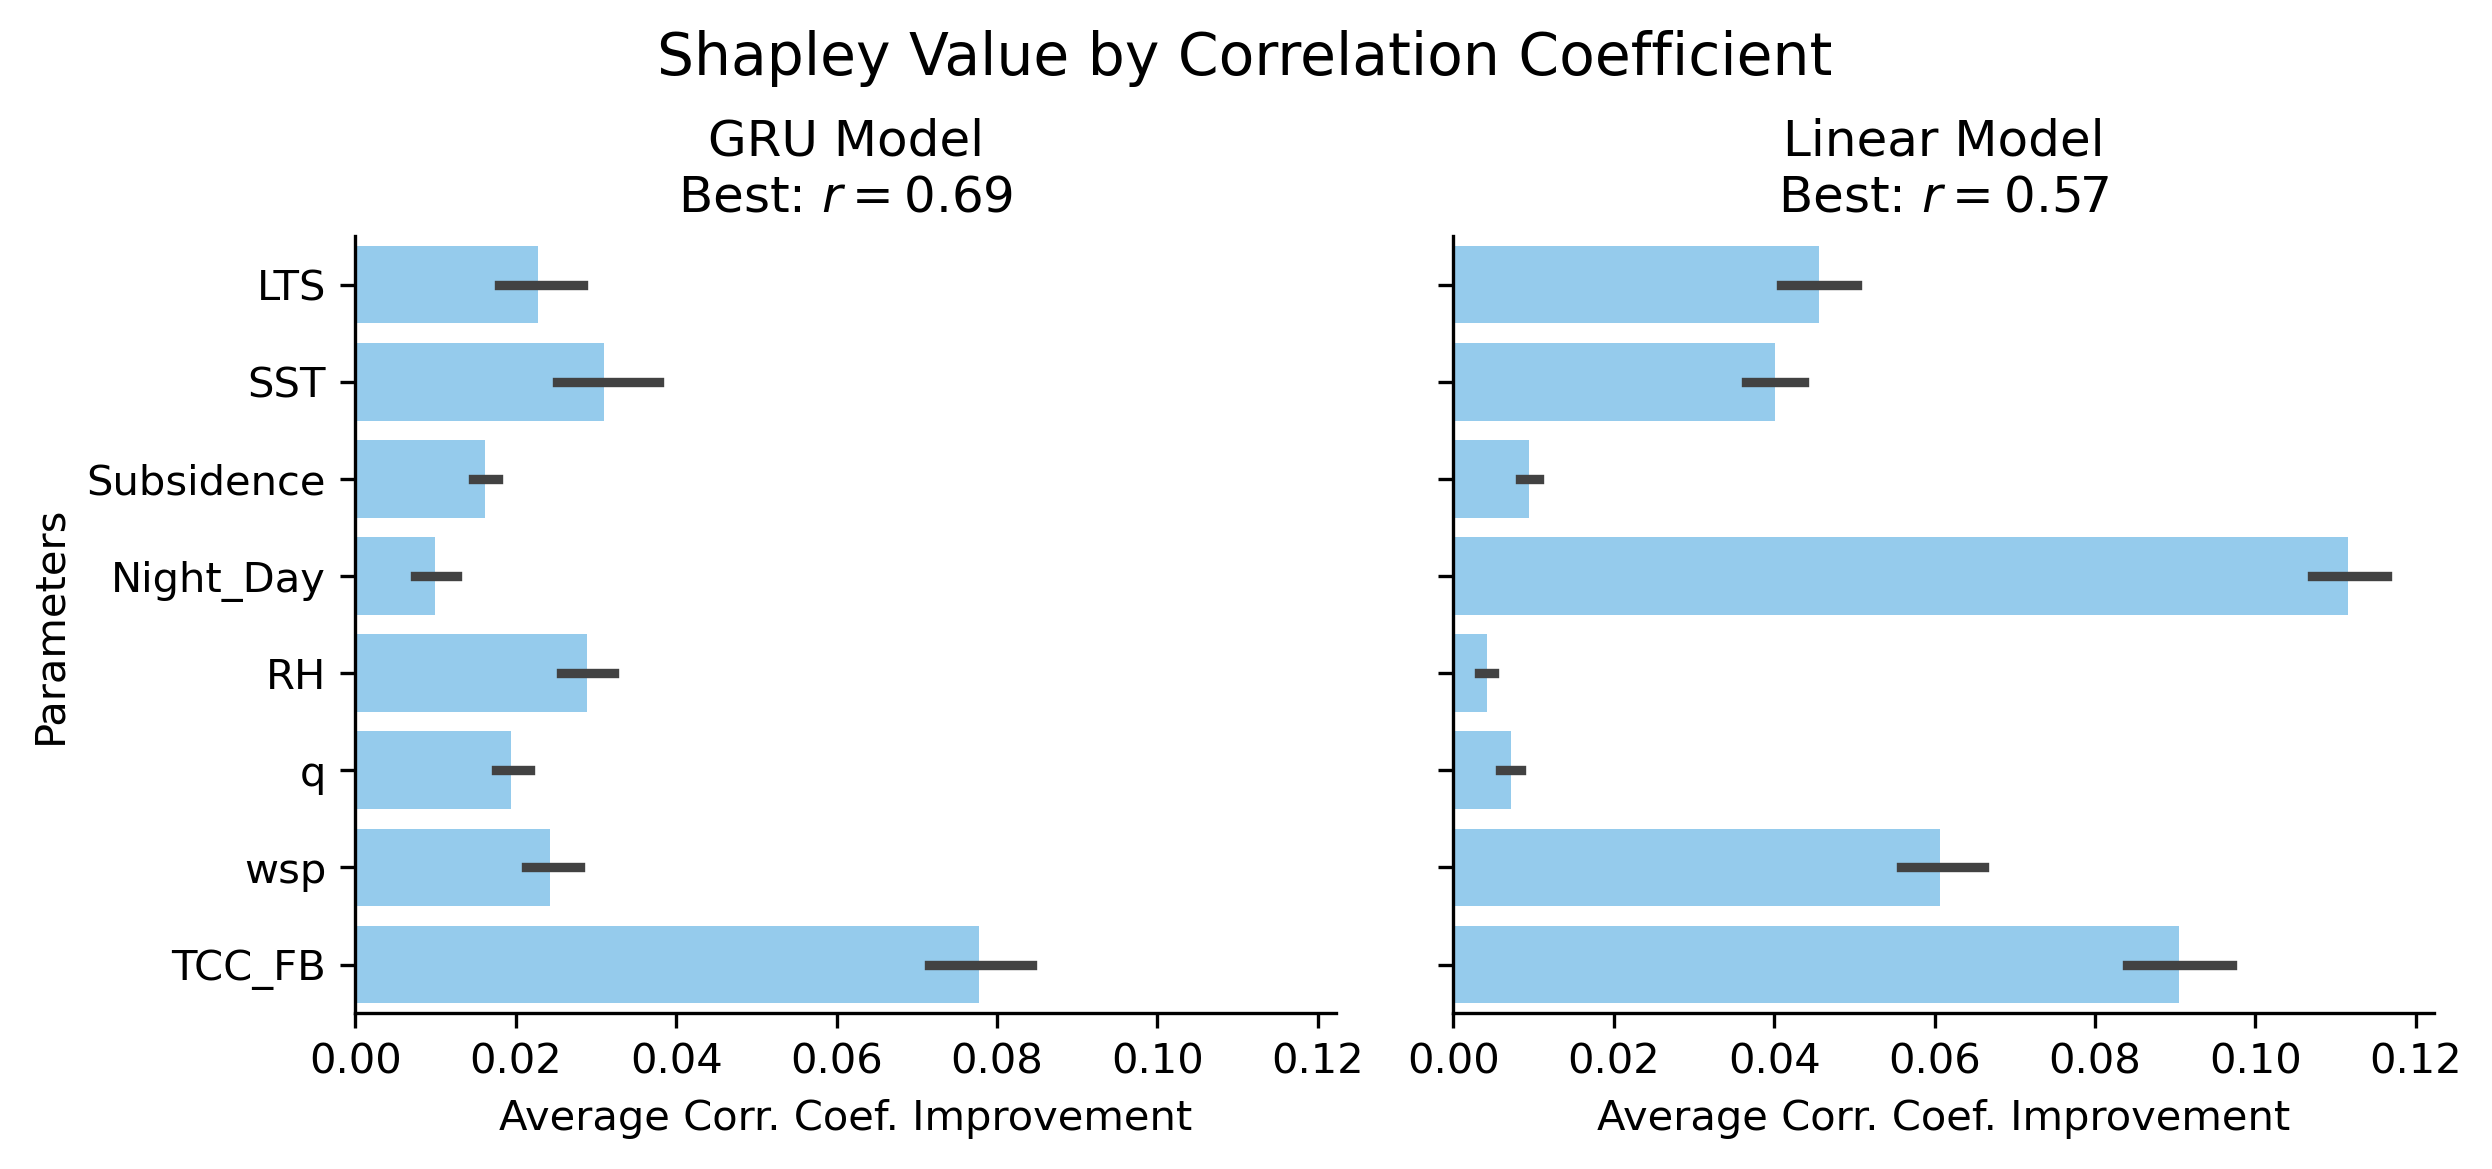

In [49]:
best_performer = ResultIndexer(df_res)()["RVALUE"]

g = sns.catplot(
    data=shapley_values_no_average_df,
    x="shapley_value",
    y="label",
    col="model",
    kind="bar",
    color="lightskyblue",
    height=3.5, 
    aspect=1.2, 
    
)

g.axes[0, 0].set(
    ylabel="Parameters",
    xlabel="Average Corr. Coef. Improvement",
    title="GRU Model\nBest: $r={:.2f}$".format(np.round(best_performer["GRU"], 2)),
)
g.axes[0, 1].set(
    xlabel="Average Corr. Coef. Improvement",
    title="Linear Model\nBest: $r={:.2f}$".format(best_performer["LINEAR"]),
)
g.figure.suptitle("Shapley Value by Correlation Coefficient", fontsize=14, y=1.1)


plt.show()

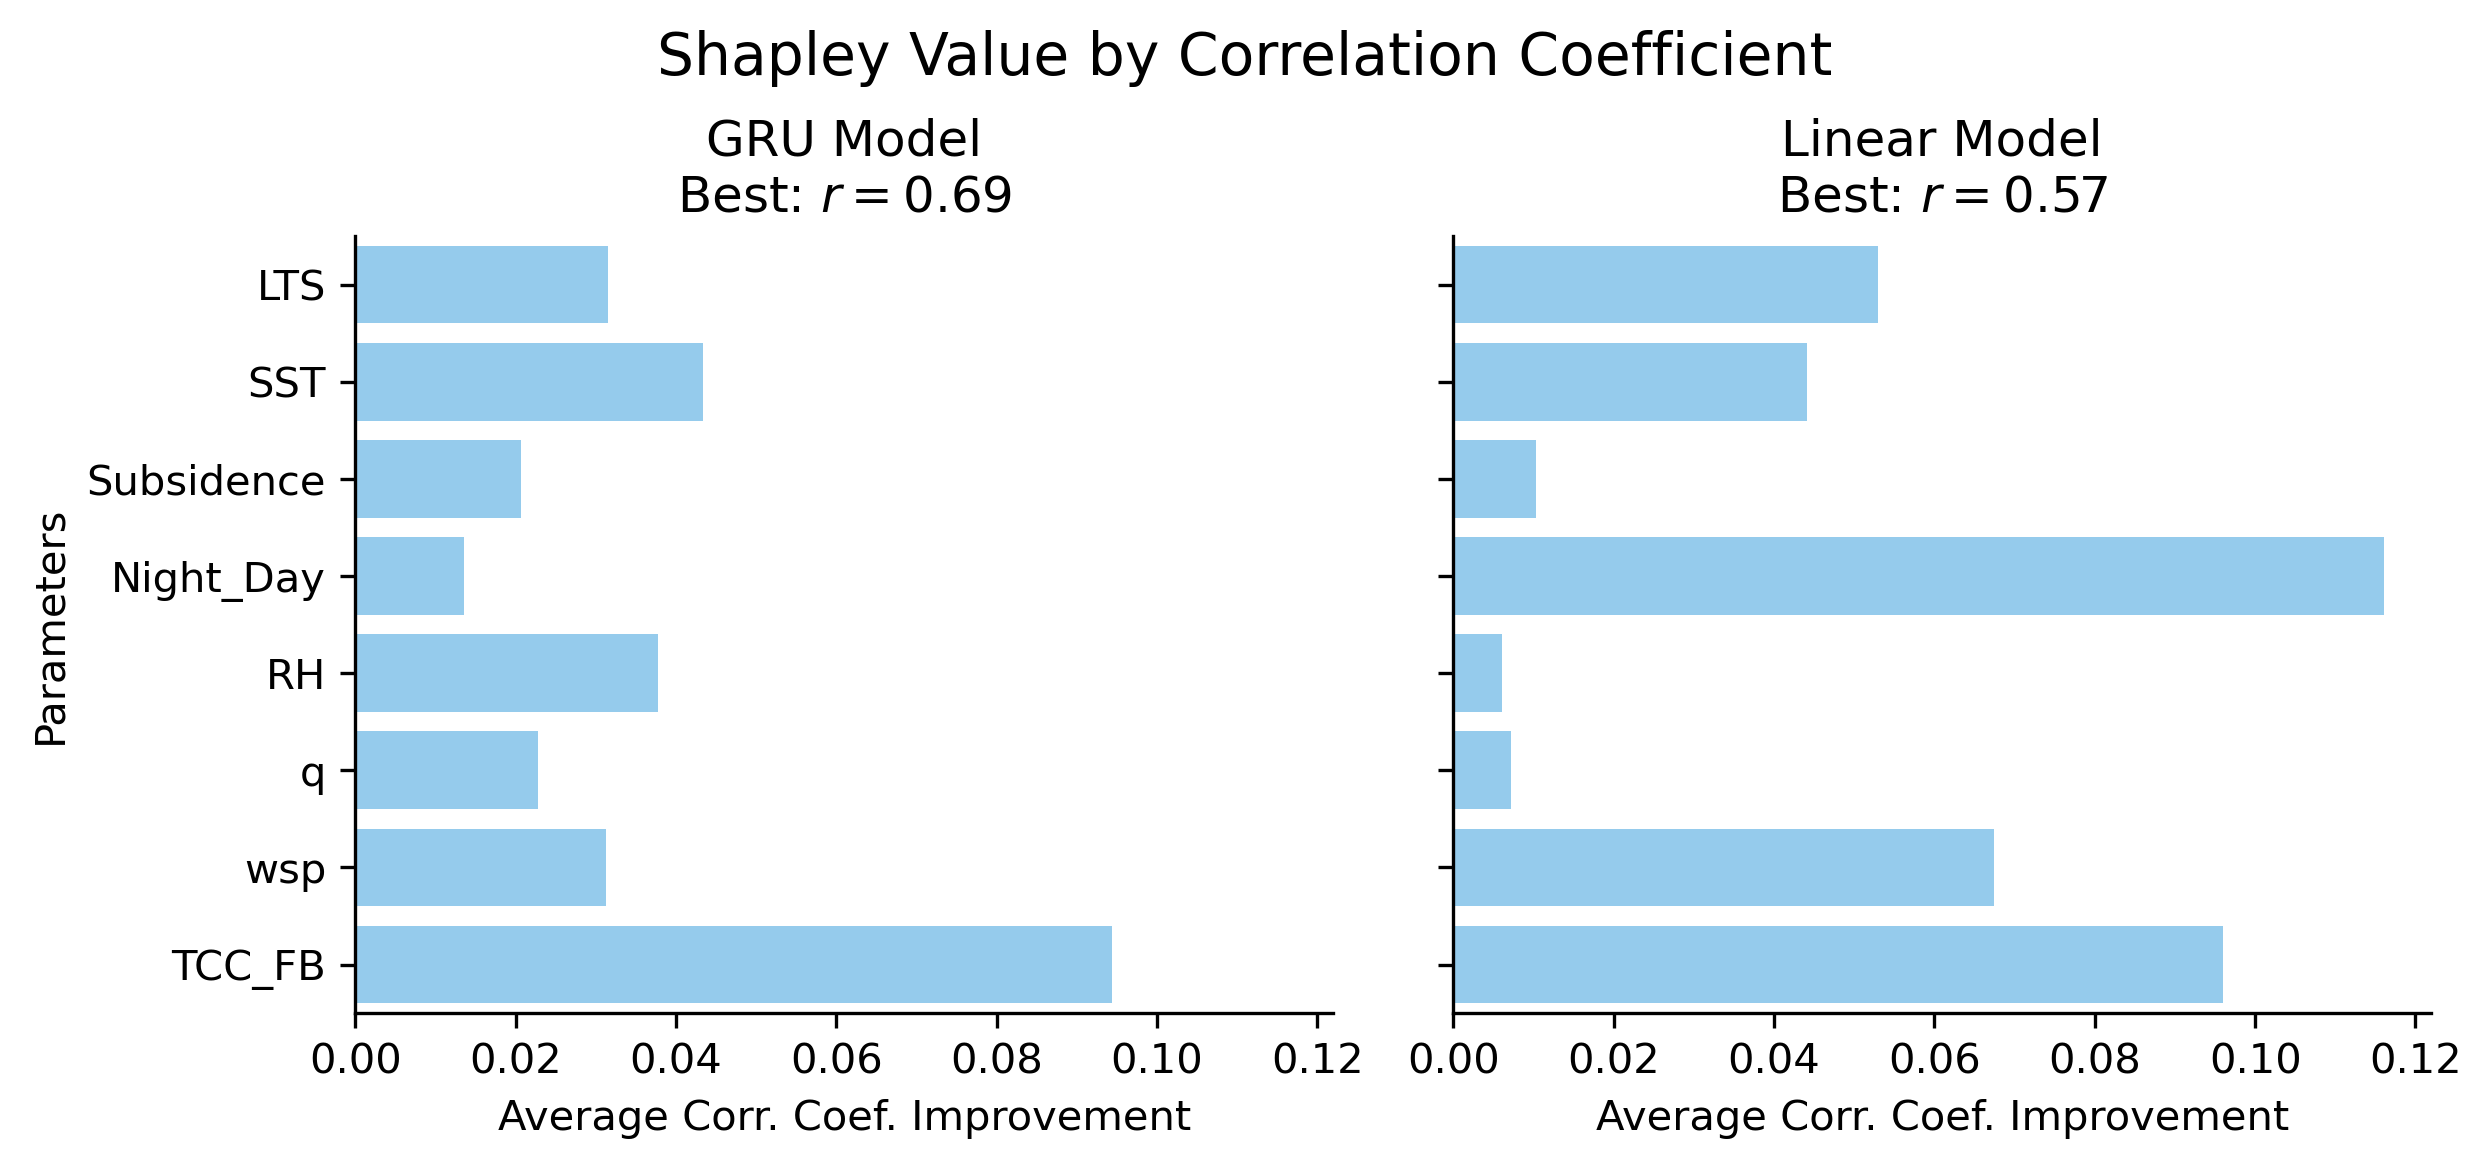

In [31]:
best_performer = ResultIndexer(df_res)()["RVALUE"]

g = sns.catplot(
    data=shapley_df[
        (shapley_df["metric"] == "RVALUE")
    ],
    x="shapley_value",
    y="label",
    col="model",
    kind="bar",
    color="lightskyblue",
    height=3.5, 
    aspect=1.2, 
    
)

g.axes[0, 0].set(
    ylabel="Parameters",
    xlabel="Average Corr. Coef. Improvement",
    title="GRU Model\nBest: $r={:.2f}$".format(np.round(best_performer["GRU"], 2)),
)
g.axes[0, 1].set(
    xlabel="Average Corr. Coef. Improvement",
    title="Linear Model\nBest: $r={:.2f}$".format(best_performer["LINEAR"]),
)
g.figure.suptitle("Shapley Value by Correlation Coefficient", fontsize=14, y=1.1)


plt.show()

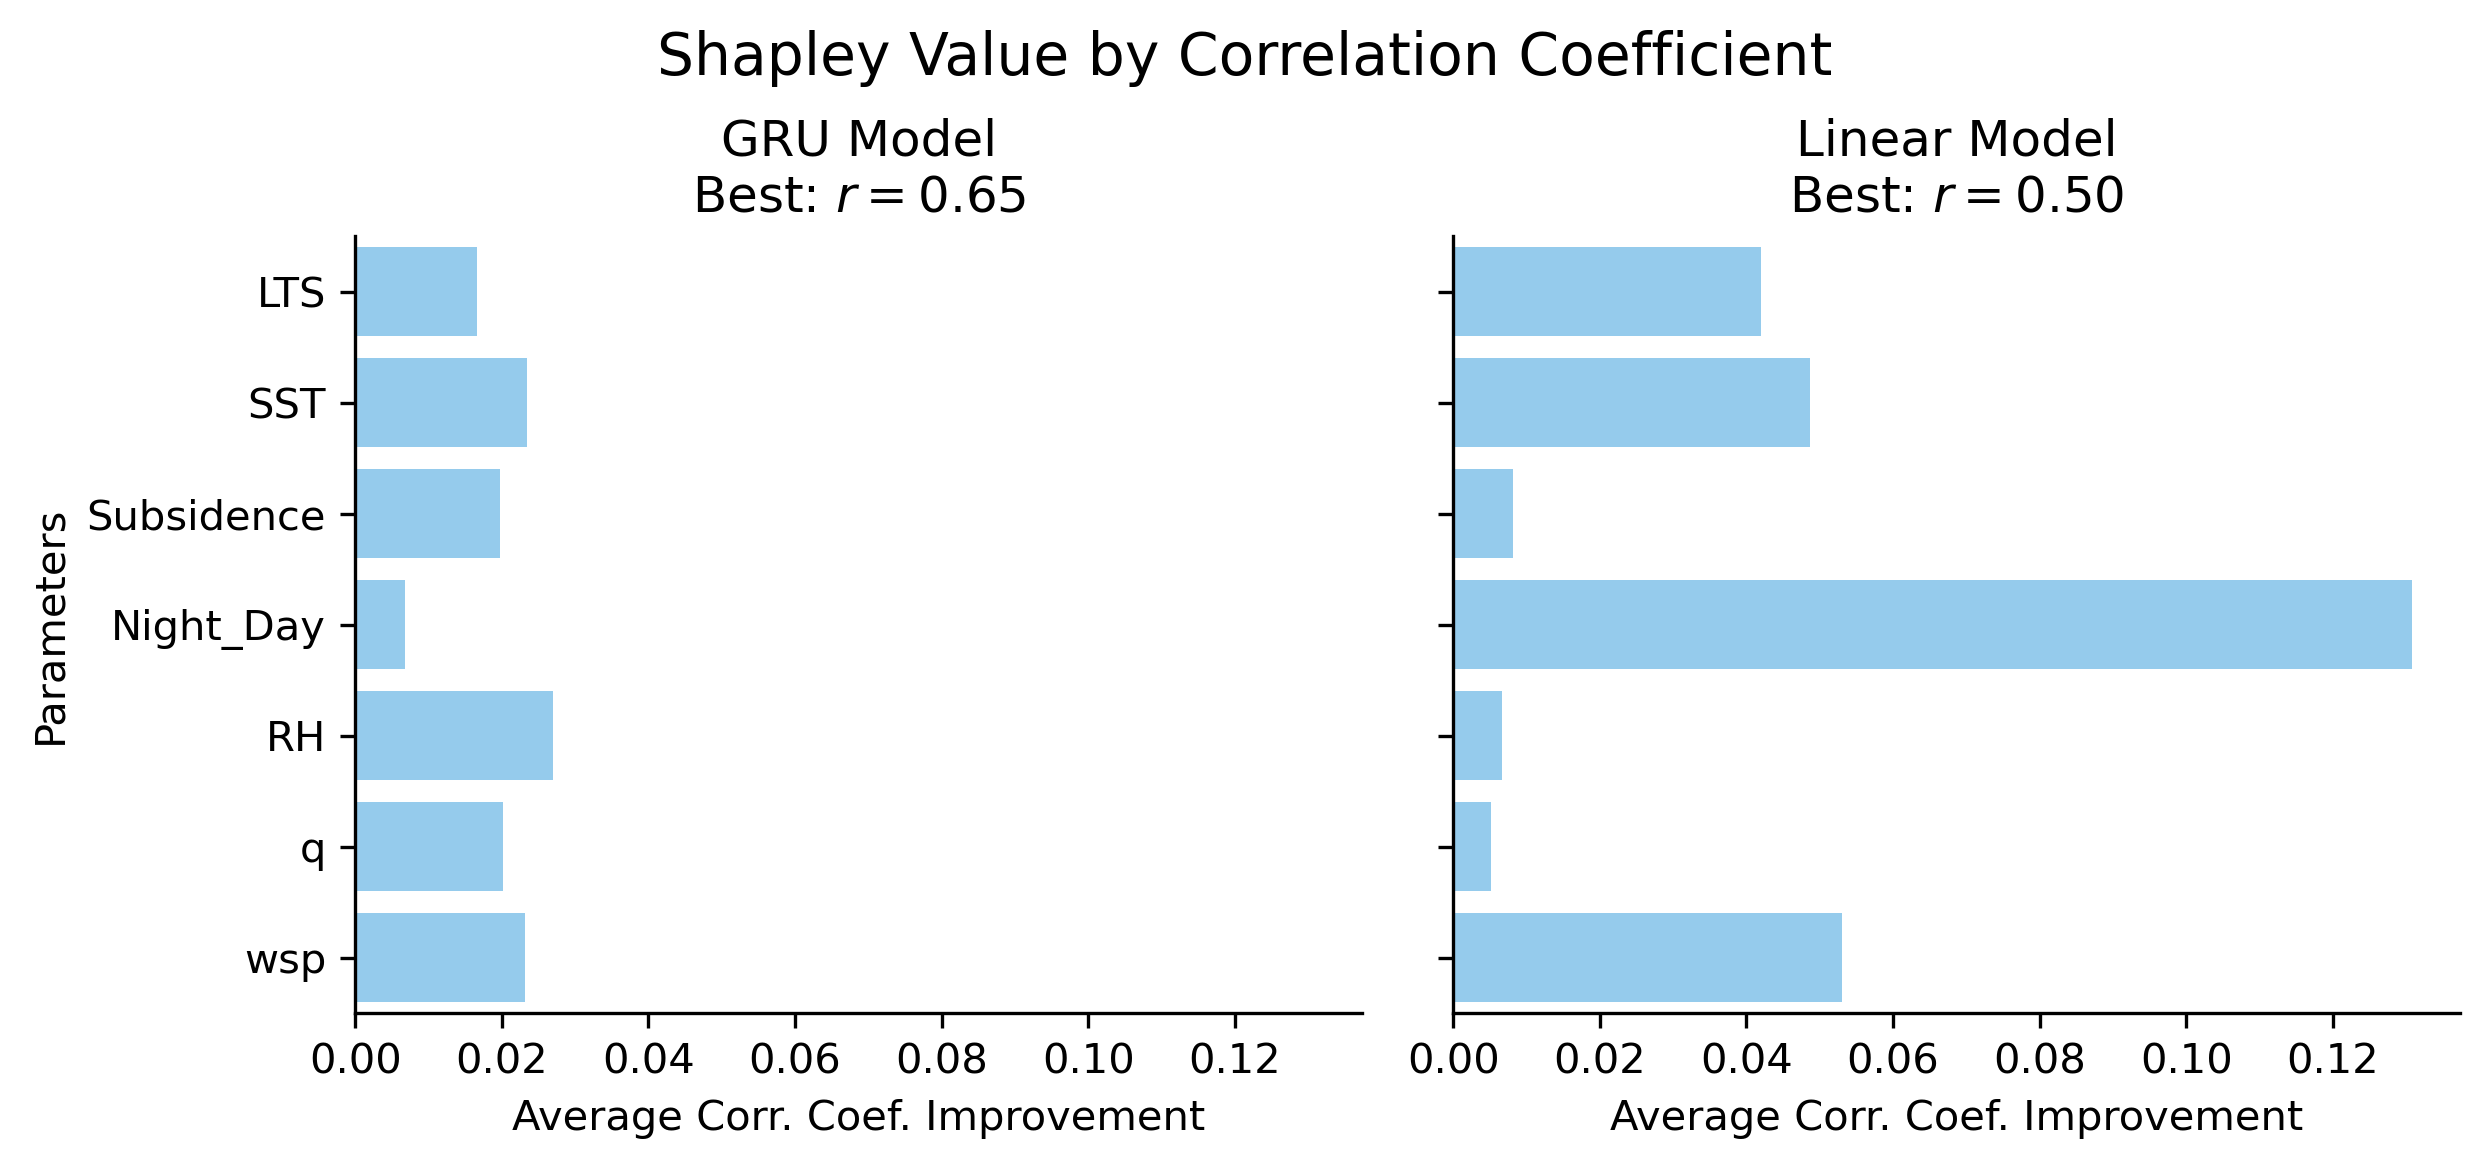

In [32]:
best_performer = ResultIndexer(df_res)["TCC_FB"]()["RVALUE"]

g = sns.catplot(
    data=shapley_df_no_TCC_FB[
        (shapley_df_no_TCC_FB["metric"] == "RVALUE")
    ],
    x="shapley_value",
    y="label",
    col="model",
    kind="bar",
    color="lightskyblue",
    height=3.5, 
    aspect=1.2, 
    
)

g.axes[0, 0].set(
    ylabel="Parameters",
    xlabel="Average Corr. Coef. Improvement",
    title="GRU Model\nBest: $r={:.2f}$".format(np.round(best_performer["GRU"], 2)),
)
g.axes[0, 1].set(
    xlabel="Average Corr. Coef. Improvement",
    title="Linear Model\nBest: $r={:.2f}$".format(best_performer["LINEAR"]),
)
g.figure.suptitle("Shapley Value by Correlation Coefficient", fontsize=14, y=1.1)


plt.show()

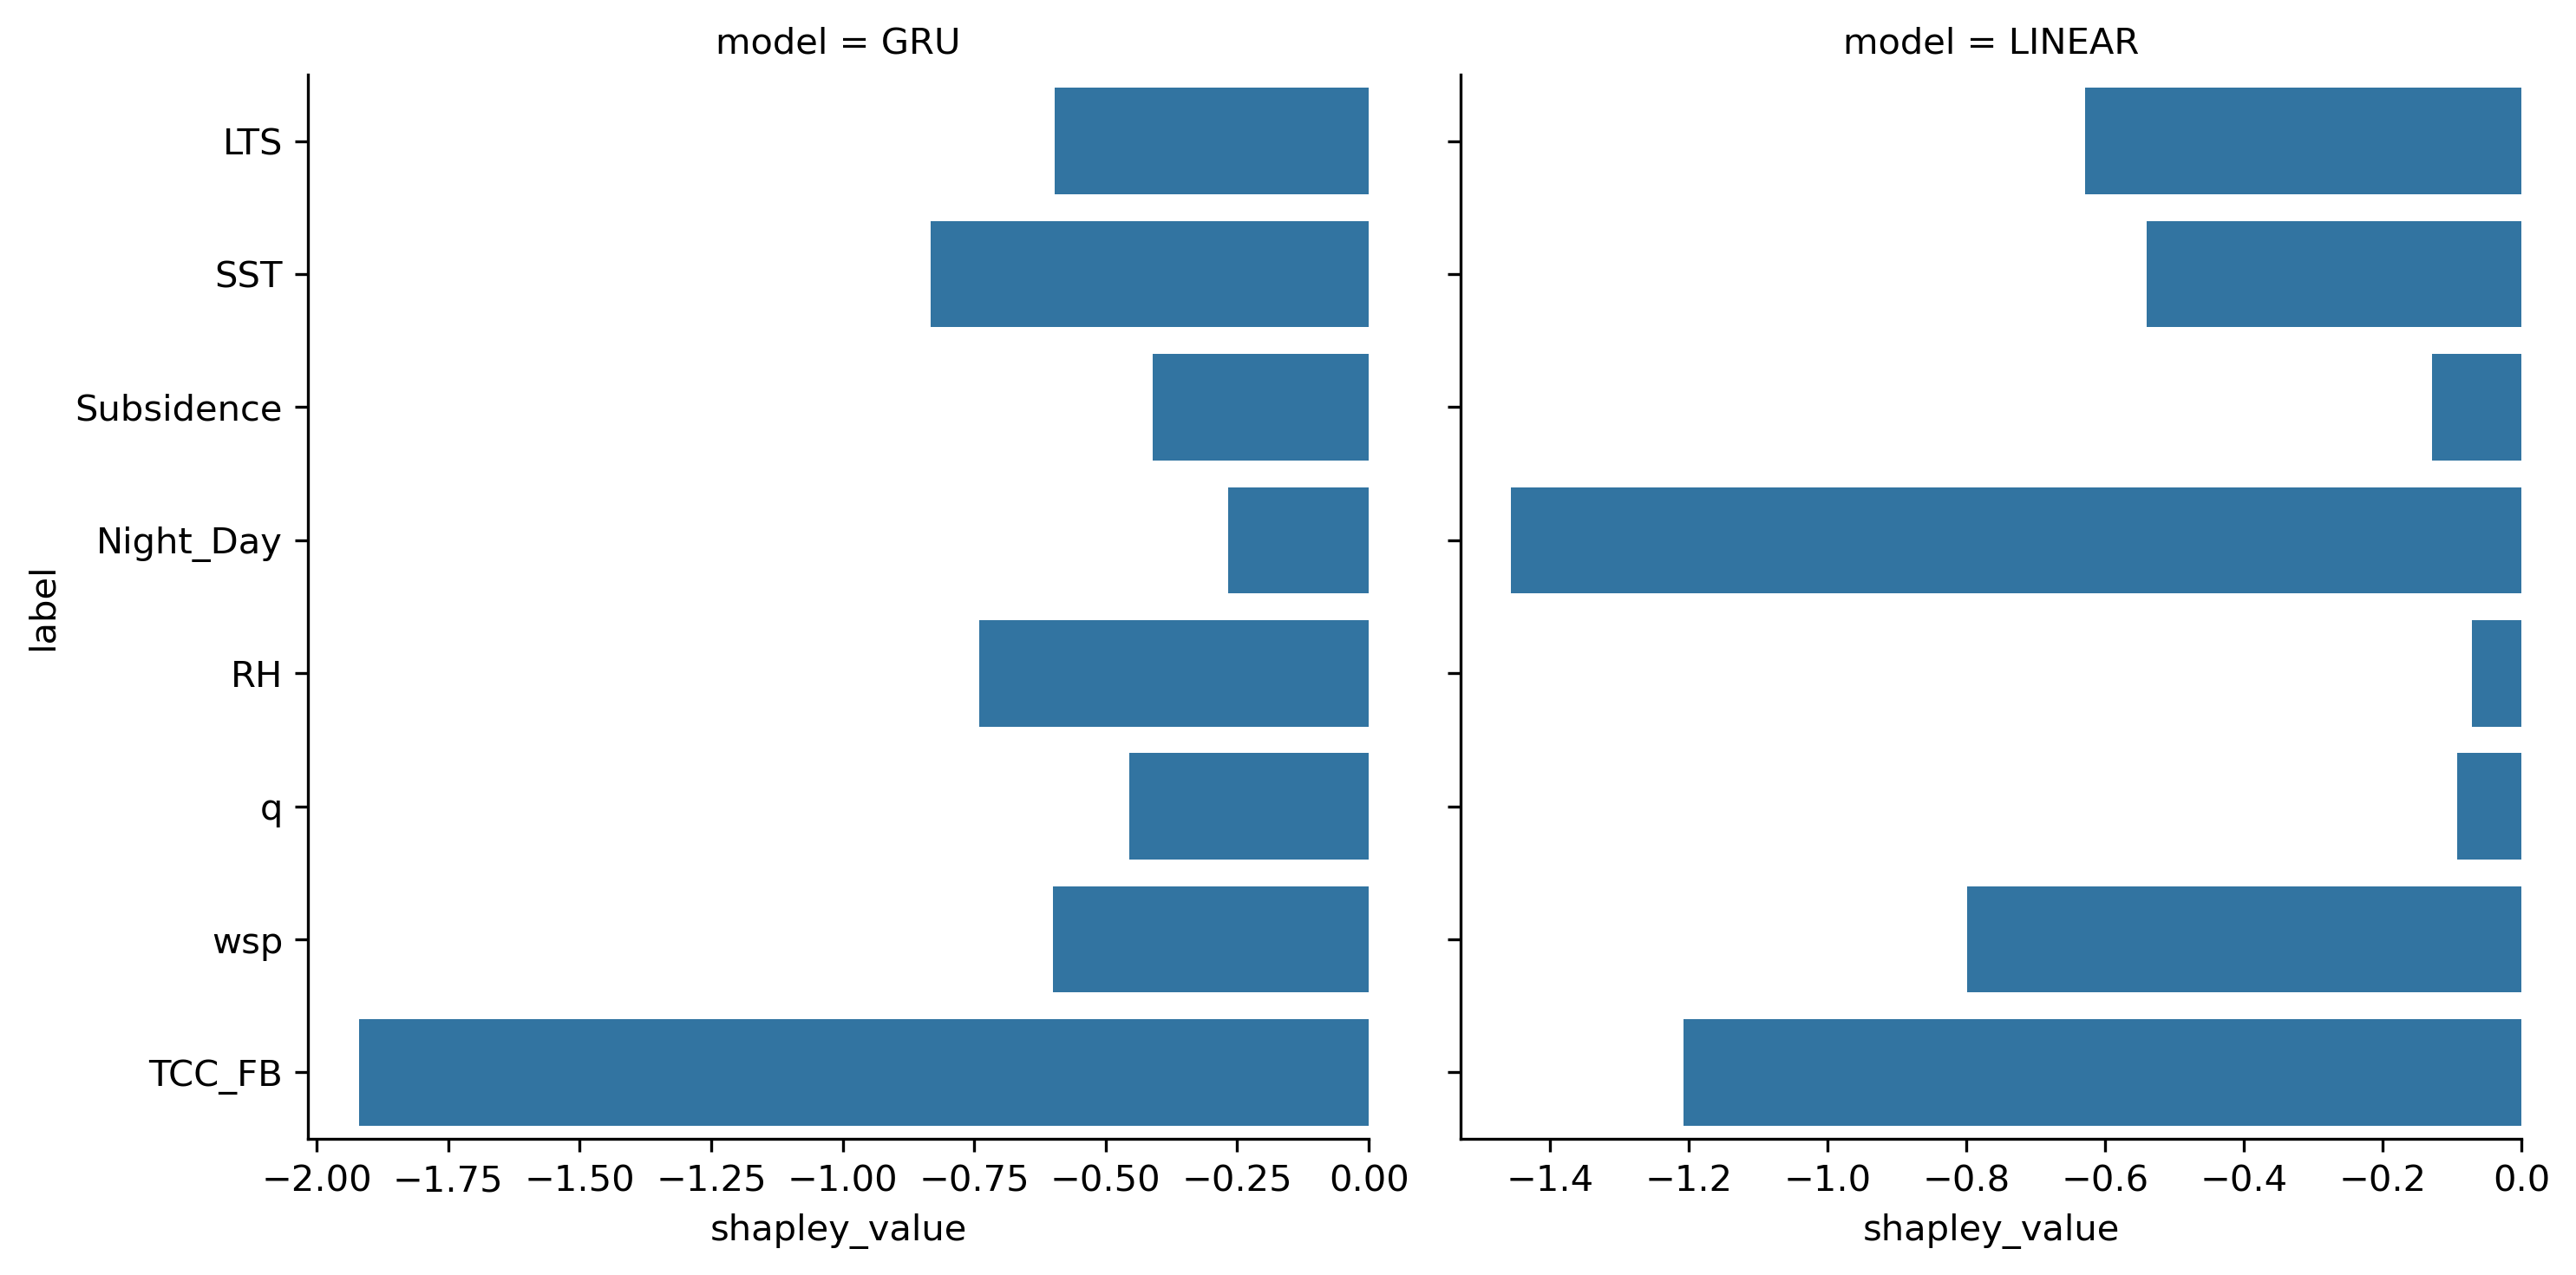

In [33]:
sns.catplot(
    data=shapley_df[
        (shapley_df["metric"] == "RMSE")
    ],
    x="shapley_value",
    y="label",
    col="model",
    kind="bar",
    sharex=False
)
plt.show()

In [34]:
shapley_df[
    ((shapley_df["metric"] == "RMSE") | (shapley_df["metric"] == "RVALUE"))
].pivot(
    index=["metric", "model"],
    columns=["label"],
    values="shapley_value"
)

label               LTS  Night_Day        RH       SST  Subsidence    TCC_FB  \
metric model                                                                   
RMSE   GRU    -0.596704  -0.266608 -0.740275 -0.832579   -0.411229 -1.919981   
       LINEAR -0.628783  -1.456132 -0.070873 -0.539512   -0.128654 -1.207133   
RVALUE GRU     0.031552   0.013554  0.037707  0.043317    0.020698  0.094360   
       LINEAR  0.053019   0.116124  0.006032  0.044105    0.010263  0.096033   

label                 q       wsp  
metric model                       
RMSE   GRU    -0.455151 -0.599624  
       LINEAR -0.092816 -0.798636  
RVALUE GRU     0.022845  0.031245  
       LINEAR  0.007160  0.067398

In [35]:
shapley_df[
    ((shapley_df["metric"] == "RMSE") | (shapley_df["metric"] == "RVALUE"))
].pivot(
    index=["label"],
    columns=["metric", "model"],
    values="shapley_value",
)

metric          RMSE              RVALUE          
model            GRU    LINEAR       GRU    LINEAR
label                                             
LTS        -0.596704 -0.628783  0.031552  0.053019
Night_Day  -0.266608 -1.456132  0.013554  0.116124
RH         -0.740275 -0.070873  0.037707  0.006032
SST        -0.832579 -0.539512  0.043317  0.044105
Subsidence -0.411229 -0.128654  0.020698  0.010263
TCC_FB     -1.919981 -1.207133  0.094360  0.096033
q          -0.455151 -0.092816  0.022845  0.007160
wsp        -0.599624 -0.798636  0.031245  0.067398

In [36]:
shapley_df[
    (shapley_df["metric"] == "RVALUE")
].pivot(
    index=["metric", "model"],
    columns=["label"],
    values="shapley_value"
)

label               LTS  Night_Day        RH       SST  Subsidence    TCC_FB  \
metric model                                                                   
RVALUE GRU     0.031552   0.013554  0.037707  0.043317    0.020698  0.094360   
       LINEAR  0.053019   0.116124  0.006032  0.044105    0.010263  0.096033   

label                 q       wsp  
metric model                       
RVALUE GRU     0.022845  0.031245  
       LINEAR  0.007160  0.067398

In [37]:
shapley_df[
    (shapley_df["metric"] == "RVALUE")
].pivot(
    index=["label"],
    columns=["model"],
    values="shapley_value"
)

model,GRU,LINEAR
label,,
LTS,0.031552,0.053019
Night_Day,0.013554,0.116124
RH,0.037707,0.006032
SST,0.043317,0.044105
Subsidence,0.020698,0.010263
TCC_FB,0.094360,0.096033
q,0.022845,0.007160
wsp,0.031245,0.067398
